In [2]:
# lime_explain.py
# sudo -E /opt/tljh/user/bin/pip3 install lime

# conda activate jupyterlab-debugger38


In [3]:
from lime.lime_image import *
# import lime
import pandas as pd
import yaml #pyyaml
import os
import datetime
import dill
import cv2 #opencv-python
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sys
#sys.path.append('/home/ubuntu/covid-cxr/src/')
sys.path.insert(0, os.path.abspath('../'))
from visualization.visualize import visualize_explanation
from predict import predict_instance, predict_and_explain
from data.preprocess import remove_text

In [4]:
def setup_lime():
    '''
    Load relevant information and create a LIME Explainer
    :return: dict containing important information and objects for explanation experiments
    '''

    # Load relevant constants from project config file
    cfg = yaml.full_load(open("/home/ubuntu/covid-cxr/config.yml", 'r'))
    lime_dict = {}
    lime_dict['NUM_SAMPLES'] = cfg['LIME']['NUM_SAMPLES']
    lime_dict['NUM_FEATURES'] = cfg['LIME']['NUM_FEATURES']
    lime_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    lime_dict['RAW_DATA_PATH'] = cfg['PATHS']['RAW_DATA']
    lime_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    lime_dict['PRED_THRESHOLD'] = cfg['PREDICTION']['THRESHOLD']
    lime_dict['CLASSES'] = cfg['DATA']['CLASSES']
    lime_dict['CLASS_MODE'] = cfg['TRAIN']['CLASS_MODE']
    lime_dict['COVID_ONLY'] = cfg['LIME']['COVID_ONLY']
    KERNEL_WIDTH = cfg['LIME']['KERNEL_WIDTH']
    FEATURE_SELECTION = cfg['LIME']['FEATURE_SELECTION']

    # Load train and test sets
    lime_dict['TRAIN_SET'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    lime_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=lime_dict['TEST_SET'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', validate_filenames=False, shuffle=False)
    lime_dict['TEST_GENERATOR'] = test_generator

    # Define the LIME explainer
    lime_dict['EXPLAINER'] = LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION,
                                                verbose=True)
    dill.dump(lime_dict['EXPLAINER'], open(cfg['PATHS']['LIME_EXPLAINER'], 'wb'))    # Serialize the explainer

    # Load trained model's weights
    lime_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)

    return lime_dict

In [5]:
def explain_xray(lime_dict, idx, save_exp=True):
    '''
    Make a prediction and provide a LIME explanation
    :param lime_dict: dict containing important information and objects for explanation experiments
    :param idx: index of image in test set to explain
    :param save_exp: Boolean indicating whether to save the explanation visualization
    '''

    # Get i'th preprocessed image in test set
    lime_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = lime_dict['TEST_GENERATOR'].next()
    x = np.squeeze(x, axis=0)
    x

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread(lime_dict['RAW_DATA_PATH'] + lime_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(lime_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Make a prediction for this image and retrieve a LIME explanation for the prediction
    start_time = datetime.datetime.now()
    #explanation = explainer.explain_instance(images[0].astype('double') # added double for tensorflow2_latest_p37
    explanation, probs = predict_and_explain(x.astype('double'), lime_dict['MODEL'], lime_dict['EXPLAINER'],
                                            lime_dict['NUM_FEATURES'], lime_dict['NUM_SAMPLES'])
    print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")


    # Get image filename and label
    img_filename = lime_dict['TEST_SET']['filename'][idx]
    label = lime_dict['TEST_SET']['label'][idx]

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_dict['TEST_GENERATOR'].class_indices]

    # Visualize the LIME explanation and optionally save it to disk
    if save_exp:
        file_path = lime_dict['IMG_PATH']
    else:
        file_path = None
    if lime_dict['COVID_ONLY'] == True:
        label_to_see = lime_dict['TEST_GENERATOR'].class_indices['COVID-19']
    else:
        label_to_see = 'top'
    _ = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                          dir_path=file_path)
    return



Found 182 non-validated image filenames belonging to 2 classes.



Intercept -0.08109976912624758
Prediction_local [0.22462298]
Right: 0.22185671
Intercept 1.0810997829695892
Prediction_local [0.77537701]
Right: 0.7781433
Explanation time = 10.709869 seconds


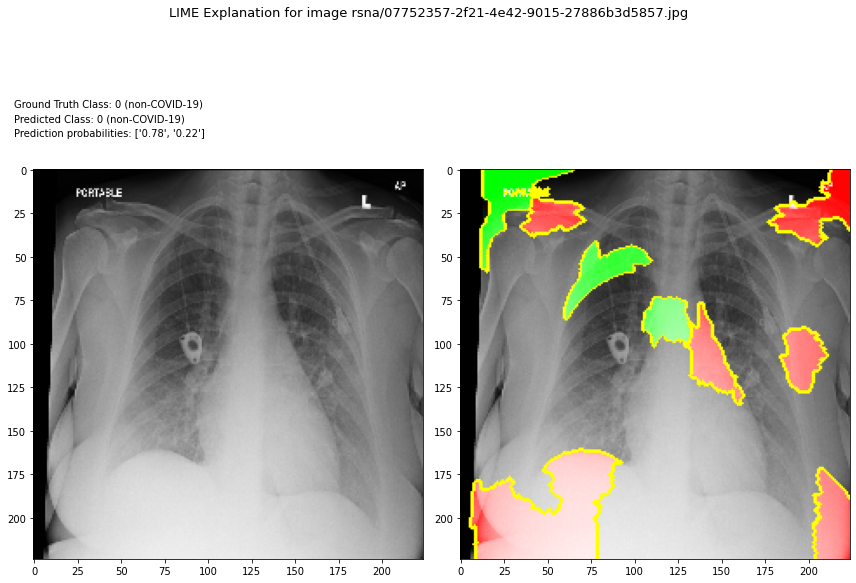

In [6]:

if __name__ == '__main__':
    lime_dict = setup_lime()
    i = 3                                          # Select i'th image in test set
    explain_xray(lime_dict, i, save_exp=True)                   # Generate explanation for image